# V02 - Proyecto Parte 1

En esta parte del proyecto, vamos a preparar los datos para el entrenamiento y a crear y entrenar nuestro modelo de machine learning basado en redes neuronales recurrentes profundas.<br>
Como parte del procesamiento de datos, analizaremos el desbalance de clases o equilibrio de datos.<br>
Los pasos que seguiremos son:<br>
- Carga de datos: Buys.csv y Sells.csv
- Análisis de desbalance de clases
- Escalado de datos
- Crear función para generar las secuencias que usaremos para entrenar nuestro modelo
- Crear la función para balancear nuestro conjunto de datos de entrenamiento (secuencias generadas previamente) usando el método de submuestreo y sobremuestreo
- Entrenamiento del modelo
- Evaluar las métricas del modelo
- Obtener una conclusión

## MÉTRICAS
1. **Accuracy (Exactitud)**
2. **Precision (Precisión)**
3. **Recall (Sensibilidad o Exhaustividad)**
4. **F1-Score**
5. **AUC-ROC (Área bajo la Curva ROC)**
6. **Matriz de Confusión**



**IMPORTAMOS LIBRERIAS**

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt

**CARGAMOS LOS DATOS**

In [2]:
Buys= pd.read_csv('Buys.csv')
Buys['time'] = pd.to_datetime(Buys['time'])
Sells= pd.read_csv('Sells.csv')
Sells['time'] = pd.to_datetime(Sells['time'])
#Eliminamos las columnas que no necesitamos
Buys = Buys.drop(['Buy'], axis=1).drop(['time'], axis=1)
Sells = Sells.drop(['Buy'], axis=1).drop(['time'], axis=1)

In [3]:
Buys.head(2)

,open,high,low,close,tick_volume,spread,real_volume,DayOfYear,Hour,Minute,Tres,Dos,PuntoCinco
0,39965.25,39965.25,39959.55,39960.55,28.0,210,0.0,137,0,0,0.0,0.0,0.0
1,39961.05,39961.05,39955.45,39957.45,15.0,230,0.0,137,0,1,0.0,0.0,0.0


Usaremos un modelo de machine learning basado en redes neuronales recurrentes profundas.<br>
Para preparar los datos de entrenamiento de este modelo, es necesario seguir los siguientes pasos:

- **Paso 1:** Análisis de desbalance de clases
- **Paso 2:** Elección de características y escalado de los datos
- **Paso 3:** Crear función para calcular secuencias y usarla
- **Paso 4:** Crear función para balancear las clases y usarla
- **Paso 5:** Dividir los datos en entrenamiento y validación



**PASO 1:** 

Como podemos notar abajo, definitivamente hay un desbalance de clases.<br>
- Tenemos más de 10 veces más clases negativas (0) que clases positivas (1).

In [4]:
display(Buys['Tres'].value_counts())
display(Sells['Tres'].value_counts())

Tres
0.0    121128
1.0      9544
Name: count, dtype: int64

Tres
0.0    120426
1.0     10246
Name: count, dtype: int64

Vamos a entrenar 3 modelos diferentes, lo que dará un total de 6 modelos. Esto nos permitirá manejar el desbalance de clases de forma más eficiente, ya que, al ser datos secuenciales, el problema ya es complicado de gestionar.

- Entrenar diferentes modelos nos permitirá visualizar la matriz de confusión y evaluar mejor el rendimiento.

Analicemos un poco los datos para decidir qué hacer.

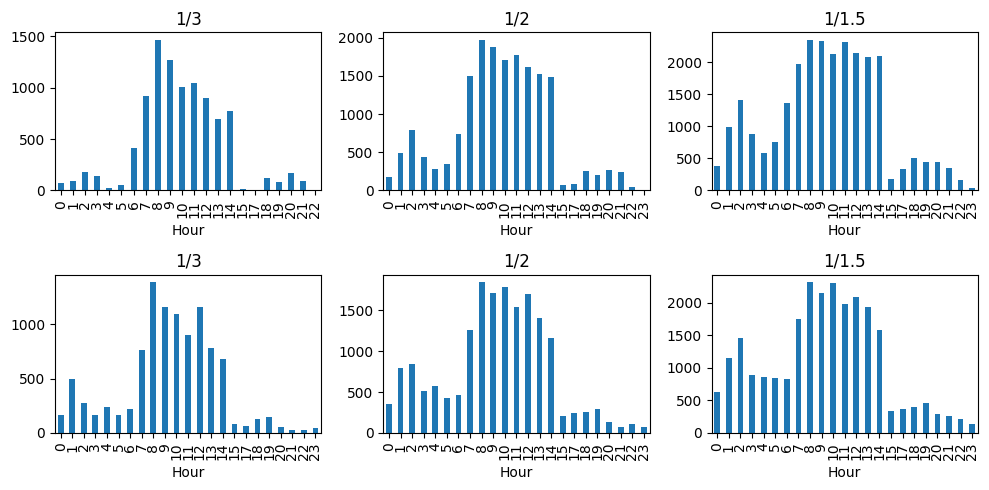

In [5]:
Buys.iloc[:,-1].value_counts()
#----------------------------------Vemamos en que orarios se dan las compras--------------------------------
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
# Primera fila de gráficos
Buys[Buys['Tres'] == 1].groupby('Hour')['Tres'].count().plot(kind='bar', ax=ax[0, 0])
ax[0, 0].set_title('1/3')
Buys[Buys['Dos'] == 1].groupby('Hour')['Dos'].count().plot(kind='bar', ax=ax[0, 1])
ax[0, 1].set_title('1/2')
Buys[Buys['PuntoCinco'] == 1].groupby('Hour')['PuntoCinco'].count().plot(kind='bar', ax=ax[0, 2])
ax[0, 2].set_title('1/1.5')

# Segunda fila de gráficos
Sells[Sells['Tres'] == 1].groupby('Hour')['Tres'].count().plot(kind='bar', ax=ax[1, 0])
ax[1, 0].set_title('1/3')
Sells[Sells['Dos'] == 1].groupby('Hour')['Dos'].count().plot(kind='bar', ax=ax[1, 1])
ax[1, 1].set_title('1/2')
Sells[Sells['PuntoCinco'] == 1].groupby('Hour')['PuntoCinco'].count().plot(kind='bar', ax=ax[1, 2])
ax[1, 2].set_title('1/1.5')
plt.tight_layout()
plt.show()



Después de las **14 horas**, en prácticamente todos los tipos de operaciones, se reduce drásticamente el número de operaciones.<br>
Acciones a tomar:
- Eliminar los registros desde las 15 horas en adelante (esto reducirá el desbalance de clases).<br>

Para continuar equilibrando las clases cero con las clases uno, primero crearemos las secuencias y luego usaremos el método de sobremuestreo (oversampling) y submuestreo (undersampling).

In [6]:
#Eliminamos los datos de las 15hs en adelante
Buys=Buys[~Buys['Hour'].isin(list(range(15,24)))].copy()
Sells=Sells[~Sells['Hour'].isin(list(range(15,24)))].copy()

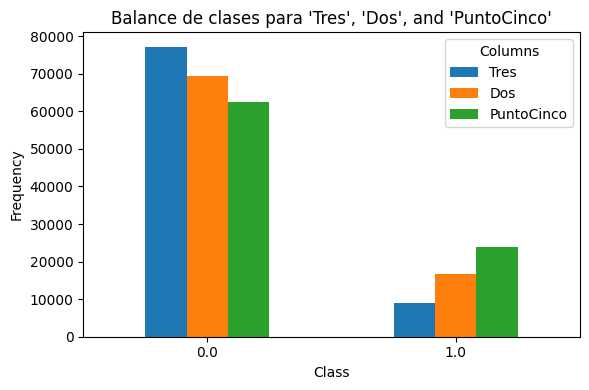

In [7]:
# Contamos el balance de cada clase (0 and 1) para cada columna
class_balance = Buys[['Tres', 'Dos', 'PuntoCinco']].apply(pd.Series.value_counts)
# Grafiucamos el balance de clases para las columnas 'Tres', 'Dos', y 'PuntoCinco'
class_balance.plot(kind='bar', figsize=(6, 4))
plt.title("Balance de clases para 'Tres', 'Dos', and 'PuntoCinco'")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.legend(title="Columns")
plt.tight_layout()
# mostramos la grafica
plt.show()


- Podemos notar que el desbalance persiste; no podemos hacer nada más aquí, ya que se trata de series temporales. Por esta razón, primero crearemos las secuencias y luego nos encargaremos de balancear las clases.

**PASO 2:**

In [8]:
#----------------------------------------PASO 2:--------------------------------------------
columnas_a_normalizar = ['open', 'high', 'low', 'close', 'tick_volume', 'spread','real_volume','Hour', 'Minute']

# Crear un objeto de MinMaxScaler
scaler = MinMaxScaler()

# Normaliza solo las columnas seleccionadas
Scaled_Buys = Buys.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Buys[columnas_a_normalizar] = scaler.fit_transform(Buys[columnas_a_normalizar])

# Hacer lo mismo para el dataframe de Sells
Scaled_Sells = Sells.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Sells[columnas_a_normalizar] = scaler.fit_transform(Sells[columnas_a_normalizar])

In [9]:
print('Sin escalar')
display(Buys.iloc[:,1:][Buys['Tres']==1].head(2))
print('Escalado')
display(Scaled_Buys[Scaled_Buys['Tres']==1].head(2))
# Como podemos notar abajo, el inidice se mantiene igual, por lo que la concatenación se hizo correctamente

Sin escalar


,high,low,close,tick_volume,spread,real_volume,DayOfYear,Hour,Minute,Tres,Dos,PuntoCinco
493,39878.85,39874.35,39878.35,44.0,180,0.0,137,8,13,1.0,1.0,1.0
494,39882.85,39877.35,39878.85,51.0,180,0.0,137,8,14,1.0,1.0,1.0


Escalado


,open,high,low,close,tick_volume,spread,real_volume,DayOfYear,Hour,Minute,Tres,Dos,PuntoCinco
493,0.402616,0.402379,0.404311,0.402832,0.080979,0.532544,0.0,137,0.571429,0.220339,1.0,1.0,1.0
494,0.402940,0.403246,0.404962,0.402940,0.094162,0.532544,0.0,137,0.571429,0.237288,1.0,1.0,1.0


Podemos notar que el escalado se realizó correctamente al coincidir los índices.<br>
Para crear las secuencias, seguiremos los siguientes pasos:<br>
- Vamos a agrupar el dataframe por **'DayOfYear'** para tener los días separados.
- Crearemos las secuencias para cada uno de estos días.

**PASO 3:**

In [10]:
def crear_secuencias(df, Y, objetivo):
    """
    Crea conjuntos de secuencias y sus respectivos targets a partir de un DataFrame.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close', 
                       'tick_volume', 'spread', 'real_volume', 'DayOfYear', 'Hour', 
                       'Minute', 'Tres'] ya estandarizadas.
    Y (int): Número de observaciones en cada secuencia.

    Retorna:
    X (np.ndarray): Arreglo de secuencias con forma (a, Y, b), donde:
                    a = número de secuencias,
                    Y = longitud de cada secuencia,
                    b = número de características (sin incluir 'DayOfYear' y 'Tres').
    y (np.ndarray): Arreglo de targets con forma (a, 1).
    """
    # Definir las columnas de características excluyendo 'DayOfYear' y 'Tres'
    caracteristicas = ['open', 'high', 'low', 'close', 
                       'tick_volume', 'spread', 'real_volume', 
                       'Hour', 'Minute']
    
    # Inicializar listas para almacenar secuencias y targets
    secuencias = []
    targets = []
    
    # Agrupar el DataFrame por 'DayOfYear'
    grupos_dia = df.groupby('DayOfYear')
    
    for dia, grupo in grupos_dia:
        # Asegurarse de que los datos estén ordenados por 'Hour' y 'Minute'
        grupo_ordenado = grupo.sort_values(['Hour', 'Minute']).reset_index(drop=True)
        
        # Extraer los valores de las características y del target
        datos_caracteristicas = grupo_ordenado[caracteristicas].values
        datos_target = grupo_ordenado[objetivo].values
        
        # Crear secuencias con ventana deslizante
        for i in range(len(grupo_ordenado) - Y + 1):
            secuencia = datos_caracteristicas[i:i+Y]
            target = datos_target[i+Y-1]
            
            secuencias.append(secuencia)
            targets.append(target)
    
    # Convertir las listas a arreglos de NumPy
    X = np.array(secuencias)
    y = np.array(targets).reshape(-1, 1)
    
    return X, y

# Ejemplo de uso:
# Supongamos que tienes un DataFrame `df_estandarizado` y deseas crear secuencias de longitud 2
# Y = 2
# X, y = crear_secuencias(df_estandarizado, Y=2)
# Ahora, `X` tendrá la forma (número_de_secuencias, 2, 9) y `y` tendrá la forma (número_de_secuencias, 1)

In [11]:
#----------------------------------------MODELO RATIO 1/3--------------------------------------------
Xb_t, yb_t = crear_secuencias(Scaled_Buys, 300,'Tres')
Xs_t, ys_t= crear_secuencias(Scaled_Sells, 300,'Tres')
#----------------------------------------MODELO RATIO 1/2--------------------------------------------
#Xb_d, yb_d = crear_secuencias(Scaled_Buys, 300,'Dos')
#Xs_d, ys_d= crear_secuencias(Scaled_Sells, 300,'Dos')
#----------------------------------------MODELO RATIO 1/1.5--------------------------------------------
#Xb_p, yb_p = crear_secuencias(Scaled_Buys, 300,'PuntoCinco')
#Xs_p, ys_p= crear_secuencias(Scaled_Sells, 300,'PuntoCinco')


**PASO 4:**

In [12]:
def balancear_clases(X, y, metodo='over', random_state=None):
    """
    Equilibra las clases de un conjunto de datos mediante oversampling o undersampling.
    
    Parámetros:
    - X (np.ndarray): Arreglo de características con forma (num_muestras, longitud_secuencia, num_caracteristicas).
    - y (np.ndarray): Arreglo de etiquetas con forma (num_muestras, 1) o (num_muestras,).
    - metodo (str): Método de balanceo a utilizar. Puede ser 'over' para oversampling o 'under' para undersampling.
    - random_state (int, opcional): Semilla para reproducibilidad.
    
    Retorna:
    - X_balanceado (np.ndarray): Arreglo de características balanceado.
    - y_balanceado (np.ndarray): Arreglo de etiquetas balanceado.
    """
    if metodo not in ['over', 'under']:
        raise ValueError("El parámetro 'metodo' debe ser 'over' o 'under'.")
    
    # Asegurar que y sea 1D
    y = y.flatten()
    
    # Obtener los índices de cada clase
    clases, conteos = np.unique(y, return_counts=True)
    
    if len(clases) != 2:
        raise ValueError("Esta función solo soporta problemas de clasificación binaria.")
    
    clase_majoritaria = clases[np.argmax(conteos)]
    clase_minoritaria = clases[np.argmin(conteos)]
    conteo_majoritaria = np.max(conteos)
    conteo_minoritaria = np.min(conteos)
    
    print(f"Distribución original de clases: {dict(zip(clases, conteos))}")
    
    if conteo_majoritaria == conteo_minoritaria:
        print("Las clases ya están balanceadas. No se requiere balanceo.")
        return X, y.reshape(-1, 1)
    
    if metodo == 'over':
        # Cálculo de cuántas muestras se necesitan agregar
        cantidad_a_agregar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando oversampling. Se agregarán {cantidad_a_agregar} muestras a la clase {clase_minoritaria}.")
        
        # Obtener los índices de la clase minoritaria
        indices_minoritaria = np.where(y == clase_minoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente con reemplazo
        indices_agregar = np.random.choice(indices_minoritaria, size=cantidad_a_agregar, replace=True)
        
        # Crear las nuevas muestras
        X_agregar = X[indices_agregar]
        y_agregar = y[indices_agregar]
        
        # Concatenar las muestras nuevas con las originales
        X_balanceado = np.concatenate([X, X_agregar], axis=0)
        y_balanceado = np.concatenate([y, y_agregar], axis=0)
    
    elif metodo == 'under':
        # Cálculo de cuántas muestras se deben eliminar
        cantidad_a_eliminar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando undersampling. Se eliminarán {cantidad_a_eliminar} muestras de la clase {clase_majoritaria}.")
        
        # Obtener los índices de la clase majoritaria
        indices_majoritaria = np.where(y == clase_majoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente sin reemplazo
        indices_eliminar = np.random.choice(indices_majoritaria, size=cantidad_a_eliminar, replace=False)
        
        # Crear una máscara para mantener las muestras no eliminadas
        mascara = np.ones(len(y), dtype=bool)
        mascara[indices_eliminar] = False
        
        # Aplicar la máscara
        X_balanceado = X[mascara]
        y_balanceado = y[mascara]
    
    # Mezclar las muestras balanceadas para evitar cualquier sesgo de orden
    if metodo == 'over':
        # Solo en oversampling se agregan nuevas muestras, por lo que es útil mezclar
        indices_mezclar = np.arange(len(y_balanceado))
        np.random.shuffle(indices_mezclar)
        X_balanceado = X_balanceado[indices_mezclar]
        y_balanceado = y_balanceado[indices_mezclar]
    
    print(f"Distribución de clases después del balanceo: {dict(zip(*np.unique(y_balanceado, return_counts=True)))}")
    
    return X_balanceado, y_balanceado.reshape(-1, 1)

Apliquemos **Undersampling**

In [15]:
Xb_t_under,yb_t_under = balancear_clases(Xb_t, yb_t, metodo='under', random_state=None)
print()
Xs_t_under,ys_t_under = balancear_clases(Xs_t, ys_t, metodo='under', random_state=None)

Distribución original de clases: {0.0: 48677, 1.0: 8537}
Aplicando undersampling. Se eliminarán 40140 muestras de la clase 0.0.
Distribución de clases después del balanceo: {0.0: 8537, 1.0: 8537}

Distribución original de clases: {0.0: 48875, 1.0: 8339}
Aplicando undersampling. Se eliminarán 40536 muestras de la clase 0.0.
Distribución de clases después del balanceo: {0.0: 8339, 1.0: 8339}


**PASO 5:**

In [16]:
#----------------------------------------PASO 5:--------------------------------------------
#----------------------------------------MODELO RATIO 1/3--------------------------------------------
Xbt_train, Xbt_val, ybt_train, ybt_val = train_test_split(Xb_t_under, yb_t_under, test_size=0.25, random_state=42, shuffle=False)
Xst_train, Xst_val, yst_train, yst_val = train_test_split(Xs_t_under, ys_t_under, test_size=0.25, random_state=42, shuffle=False)
#----------------------------------------MODELO RATIO 1/2--------------------------------------------
#Xbd_train, Xbd_val, ybd_train, ybd_val = train_test_split(Xb_d, yb_d, test_size=0.25, random_state=42, shuffle=False)
#Xsd_train, Xsd_val, ysd_train, ysd_val = train_test_split(Xs_d, ys_d, test_size=0.25, random_state=42, shuffle=False)
#----------------------------------------MODELO RATIO 1/1.5--------------------------------------------
#Xbp_train, Xbp_val, ybp_train, ybp_val = train_test_split(Xb_p, yb_p, test_size=0.25, random_state=42, shuffle=False)
#Xsp_train, Xsp_val, ysp_train, ysp_val = train_test_split(Xs_p, ys_p, test_size=0.25, random_state=42, shuffle=False)

In [17]:
display(Xbt_train[0][-1])
display(ybt_train[0])
print('Xt_buys shape:', ybt_train.shape)

array([0.4129225 , 0.41215221, 0.41485048, 0.41248944, 0.00753296,
       0.47337278, 0.        , 0.28571429, 1.        ])

array([0.])

Xt_buys shape: (12805, 1)


**ENTRENAMIENTO DEL MODELO**

In [20]:
# Definir el modelo
model = Sequential()
model.add(LSTM(64, input_shape=(Xbt_train.shape[1], Xbt_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Dado que 'Tres' es binario

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(Xbt_train, ybt_train, epochs=5, batch_size=32, validation_data=(Xbt_val, ybt_val))


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 84s 202ms/step - accuracy: 0.5608 - loss: 0.6821 - val_accuracy: 0.5053 - val_loss: 0.6899
Epoch 2/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 79s 196ms/step - accuracy: 0.5717 - loss: 0.6784 - val_accuracy: 0.6046 - val_loss: 0.6624
Epoch 3/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 78s 196ms/step - accuracy: 0.6257 - loss: 0.6539 - val_accuracy: 0.6315 - val_loss: 0.6834
Epoch 4/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.6144 - loss: 0.6449 - val_accuracy: 0.6102 - val_loss: 0.6495
Epoch 5/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.6325 - loss: 0.6272 - val_accuracy: 0.6446 - val_loss: 0.6343


## MÉTRICAS

**LIBRERIAS**

In [21]:
import seaborn as sns
from tensorflow.keras.models import load_model  # Si estás cargando un modelo guardado
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

**CARGA DEL MODELO**

In [22]:
#model=load_model('modelos/BuyTres.keras', compile=False)

Realizar Predicciones
- Las predicciones se realizarán con el dataset desbalanceado con el objetivo de probar si el modelo no está prediciendo aleatoriamente.

In [36]:
# -----------------------------------------------------
# 1. Realizar Predicciones
# -----------------------------------------------------

# Obtener las predicciones de probabilidad
y_pred_prob = BuyTres.predict(Xb_t)

# Convertir las predicciones de probabilidad a clases binarias (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)

# Asegurarse de que ybt_val también esté en formato 1D
y_true = yb_t.reshape(-1)

1788/1788 ━━━━━━━━━━━━━━━━━━━━ 103s 58ms/step


Calcular las Métricas

In [37]:
# -----------------------------------------------------
# 2. Calcular las Métricas
# -----------------------------------------------------

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Generar el reporte de clasificación
class_report = classification_report(y_true, y_pred, digits=4)

Presentar las Métricas

In [38]:
# -----------------------------------------------------
# 3. Presentar las Métricas
# -----------------------------------------------------
# Crear un DataFrame para las métricas
metrics_df = pd.DataFrame({
    'Métrica': ['Exactitud (Accuracy)', 'Precisión (Precision)', 
                'Sensibilidad (Recall)', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy, precision, recall, f1, auc_roc]
    })
print("### Reporte de Métricas ###\n")
print(metrics_df)
print("\n### Reporte de Clasificación ###\n")
print(class_report)

### Reporte de Métricas ###

                 Métrica     Valor
0   Exactitud (Accuracy)  0.534030
1  Precisión (Precision)  0.213507
2  Sensibilidad (Recall)  0.791027
3               F1-Score  0.336255
4                AUC-ROC  0.690789

### Reporte de Clasificación ###

              precision    recall  f1-score   support

         0.0     0.9303    0.4890    0.6410     48677
         1.0     0.2135    0.7910    0.3363      8537

    accuracy                         0.5340     57214
   macro avg     0.5719    0.6400    0.4886     57214
weighted avg     0.8233    0.5340    0.5955     57214



Generar los Gráficos

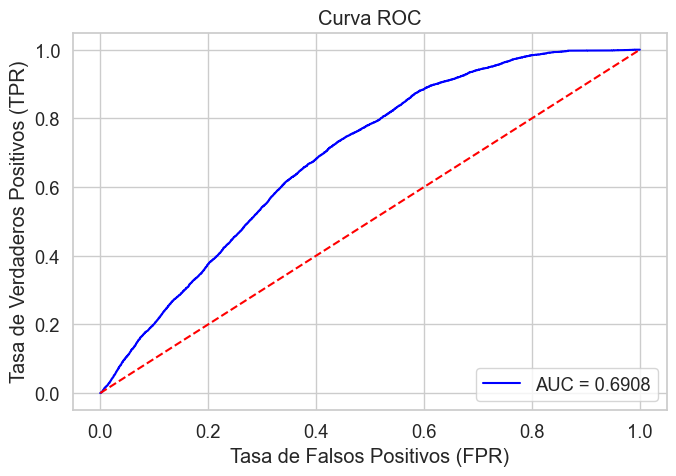

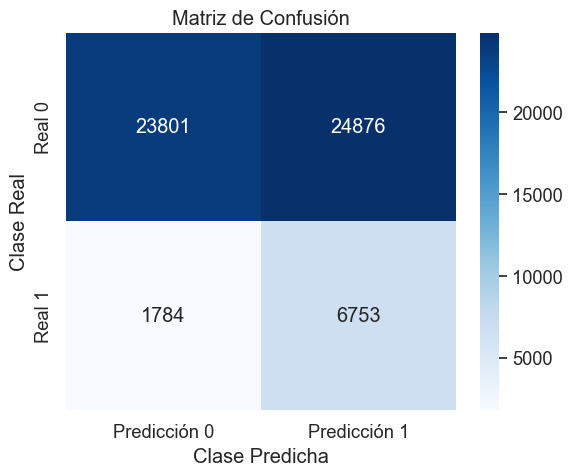

In [39]:
# -----------------------------------------------------
# 4. Generar los Gráficos
# -----------------------------------------------------
# Configuración general de los gráficos
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# a) Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# b) Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()


### **INFROME FINAL 'PORYECTO PARTE 1':**  
Este proyecto buscó llevar la **US30.Cash_strategy** (estrategia privada) a una estrategia automatizada. Para esto:

Se siguieron los siguientes procesos:

### **Recolección de datos:** 

Los datos fueron extraídos de una plataforma confiable por medio de MetaTrader 5.

### **Limpieza de datos:**

Los datos estaban en perfecto estado, ya que su fuente es finamente programada para evitar duplicados, valores nulos, etc. Los datos estaban limpios.

### **Transformación de datos:**

Se realizó **ingeniería de características** transformando la columna de tiempo a la zona horaria de mi país.  
Se eliminaron observaciones con registro en horas desde las 15H hasta las 24H.  
Durante la transformación de estos datos, fue necesario hacer un análisis y visualización previa, donde se notaron algunos puntos en la naturaleza de los datos:
- **Cierres programados:** No todos los días el mercado está abierto.
- **Descontinuación en el tiempo y en el precio:** No todos los días se cuentan las mismas velas (causa: cierres no programados del mercado).

**Acciones tomadas:**
- Descarte del primer y último día (razón: evitar complicar la descarga de datos).
- Se agregaron 4 columnas: 
  - (Buy: 0-venta, 1-compra)
  - (Tres: 0-pérdida, 1-ganada)
  - (Dos: 0-pérdida, 1-ganada)
  - (PuntoCinco: 0-pérdida, 1-ganada)
- Obtenemos 2 dataframes (Buys=1) y (Buys=0).
- Se normalizaron los datos en ambos DataFrames.
- Se crearon secuencias de los datos con 300 observaciones cada una.

### **Muestreo o equilibrio de datos:**
- Se notó un desbalance de clases en los datos donde la clase 0 predominaba con más de 12 veces la clase 1.
- Se realizó oversampling y undersampling.

### **División del conjunto de datos:**
Se dividieron los datos en conjunto de entrenamiento y validación en una proporción 75/25.

### **Selección de modelo y ajuste:**
Se creó un modelo basado en redes neuronales recurrentes profundas con tres capas de 64 neuronas cada una,  
una capa intermedia de Dropout (0.2), y una última capa densa de 1 neurona para generar la predicción con  
función de activación 'sigmoid'.  
Se compiló el modelo usando la función de pérdida `loss='binary_crossentropy'`.  
Se entrenó el modelo usando 5 épocas y un `batch_size=32`.  
El dataset de entrenamiento con undersampling contenía 16,678 secuencias de 300 observaciones cada una.  
El dataset de entrenamiento con oversampling contenía 97,354 secuencias de 300 observaciones.  
Cada secuencia tenía su respectivo target.


### **Métricas del modelo:**
El entrenamiento devolvió un modelo con:<br>
accuracy: 0.6325 - loss: 0.6272 - val_accuracy: 0.6446 - val_loss: 0.6343<br>
Sin embargo, con la muestra desbalanceada se obtuvo:

| N°  | Métrica              | Valor    |
|-----|----------------------|----------|
| 0   | Exactitud (Accuracy)  | 0.534030 |
| 1   | Precisión (Precision) | 0.213507 |
| 2   | Sensibilidad (Recall) | 0.791027 |
| 3   | F1-Score              | 0.336255 |
| 4   | AUC-ROC               | 0.690789 |

En la matriz de confusión se obtuvo:

|        | Predicción 0 | Predicción 1 |
|--------|--------------|--------------|
| Real 0 | 23,801       | 24,876       | 
| Real 1 | 1,784        | 6,753        |

### **Conclusión**
Este proyecto ha seguido un proceso largo en busca de preaparar los datos para crear un modelo funcional que genere predicciones de calidad en base a los objetivos propuestos, sin embargo esto no se ha logrado en esta parte del proyecto, durante las proximas versiones se actualizará el metodo en el que se aborda el problema partiendo desde lo analazado y conseguido en este.

### **Notas:**
- El entrenamiento del modelo con el dataset completo es computacionalmente muy costoso (40 minutos de entrenamiento). Es recomendable reducir la cantidad de observaciones por secuencia, buscando una forma de incluir información del resto de observaciones de forma implícita en el nuevo número reducido de observaciones en nuevas columnas características. Estas pueden contener algún indicador técnico.  
Para reducir el tiempo de entrenamiento también se pueden eliminar columnas características menos trascendentes.


